<a href="https://colab.research.google.com/github/silentfortin/ai-portfolio/blob/main/09-genai-powerplant/genai_powerplant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CyberEye Solutions — Generative Data Augmentation for Critical Infrastructure Security

`👩‍💻 Developed as part of the AI Engineering Master – Week 9`

📌 Project Overview

This project investigates the use of generative data augmentation techniques to improve image-based threat detection in critical infrastructure security scenarios, with a focus on electric power plants. Starting from a limited real world dataset, the pipeline combines image captioning, text paraphrasing, and text-to-image generation to create synthetic visual data that aims to increase dataset diversity and robustness.

The Oxford-IIIT Pet dataset is used as a controlled proxy for visual surveillance data, allowing systematic experimentation while preserving reproducibility. A ResNet-18 image classification model is trained and evaluated on both the original dataset and an extended dataset enriched with synthetically generated images. The objective is to assess whether generative augmentation improves classification performance, particularly in terms of accuracy and class-wise balance (macro precision, recall, and F1), which are critical metrics in security-sensitive environments.

Through a direct comparison between baseline and extended training setups, the project highlights both the potential and the limitations of uncontrolled synthetic data generation, emphasizing the importance of data quality, realism, and evaluation rigor when deploying generative techniques in critical infrastructure.



# 1 - Setup and Reproducibility

In this section device is configured and random seeds is setted to ensure
reproducibility of the experiments.

In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision import transforms as T, models
from torchvision.datasets import OxfordIIITPet, ImageFolder

In [3]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# 2 - Dataset and Preprocessing

Oxford-IIIT Pet dataset is used. The training split is further divided
into training and validation subsets. Standard data augmentation is applied
only to the training set.


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

mean_tensor = torch.tensor(mean)
std_tensor = torch.tensor(std)

In [ ]:
def denormalize(img_tensor):
    """
    img_tensor: Tensor [C,H,W] or Tensor [B,C,H,W]
    returns tensor on CPU in range [0,1]
    """
    if img_tensor.dim() == 4:
        den = img_tensor * std_tensor.view(1,3,1,1) + mean_tensor.view(1,3,1,1)
        return den.cpu().clamp(0,1)
    elif img_tensor.dim() == 3:
        den = img_tensor * std_tensor.view(3,1,1) + mean_tensor.view(3,1,1)
        return den.cpu().clamp(0,1)
    else:
        raise ValueError("img_tensor must be 3D or 4D tensor")

In [ ]:
def show_samples(dataset, n=4, title_prefix=""):
    """Show n samples from a dataset with class labels."""
    rows = 2
    cols = (n + 1) // 2
    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    axs = axs.flatten()
    for i in range(n):
        img, label = dataset[i]
        img_denorm = denormalize(img)
        axs[i].imshow(img_denorm.permute(1, 2, 0))
        axs[i].set_title(f"{title_prefix}{dataset.classes[label]}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
def show_caption_examples(records, n=2):
    """Print a few caption + paraphrases examples."""
    for i, rec in enumerate(records[:n]):
        print(f"Example {i}")
        print("  Class:    ", rec.get("class_name", "N/A"))
        print("  Caption:  ", rec.get("caption", ""))
        for j, p in enumerate(rec.get("paraphrases", [])):
            print(f"  Paraphrase {j+1}:", p)
        print()

In [ ]:
transform_train = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(mean, std)
])

transform_valtest = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean, std)
])

In [ ]:
DATA_ROOT = "OxfordIIITPet_datasets"

trainval_base = OxfordIIITPet(
    root=DATA_ROOT,
    split="trainval",
    target_types="category",
    transform=None,
    download=True
)

test_base = OxfordIIITPet(
    root=DATA_ROOT,
    split="test",
    target_types="category",
    transform=None,
    download=True
)

train_size = int(0.8 * len(trainval_base))
val_size = len(trainval_base) - train_size
train_subset, val_subset = random_split(trainval_base, [train_size, val_size])

test_subset = Subset(test_base, list(range(len(test_base))))

print(f"Train: {len(train_subset)}, Val: {len(val_subset)}, Test: {len(test_subset)}")

Train: 2944, Val: 736, Test: 3669


# Dataset Wrapper with Safe Transforms

This wrapper allows us to apply transforms consistently to Subset and
ImageFolder datasets.

In [ ]:
class SafeTransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
        self.classes = subset.dataset.classes if hasattr(subset, "dataset") else subset.classes

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [ ]:
# create datasets with transforms
train_ds = SafeTransformDataset(train_subset, transform_train)
val_ds   = SafeTransformDataset(val_subset, transform_valtest)
test_ds  = SafeTransformDataset(test_subset, transform_valtest)

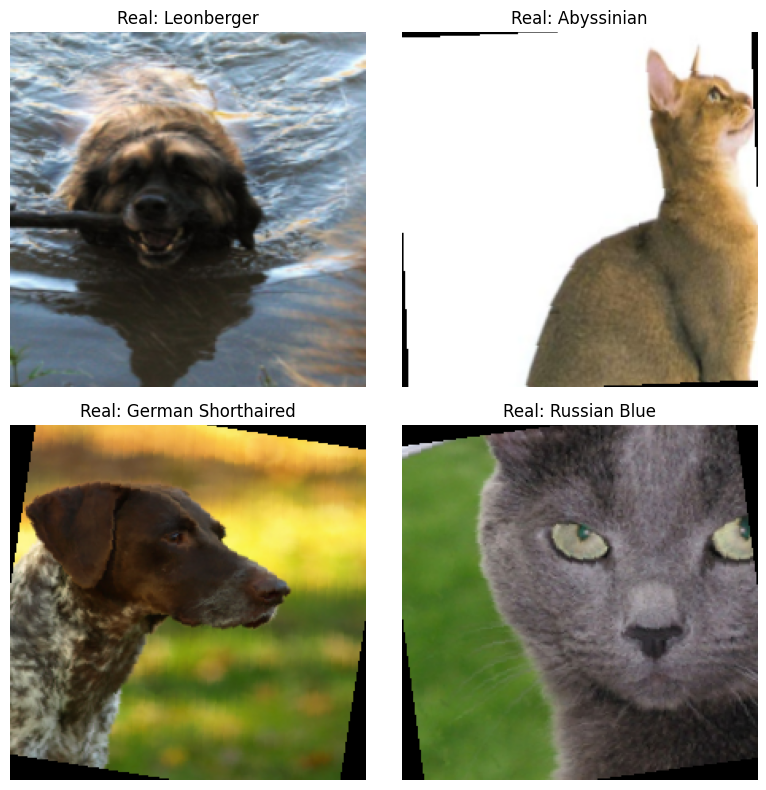

In [ ]:
show_samples(train_ds, n=4, title_prefix="Real: ")

# 3 - Baseline Model Training

Fine-tune a pretrained ResNet-18 on the real training data and evaluate
it on validation and test sets.

In [ ]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

In [ ]:
# Model, optimizer, loss
num_classes = len(trainval_base.classes)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [ ]:
def evaluate(model, loader, num_classes=num_classes):
    # Set model to evaluation mode
    model.eval()
    all_preds = []
    all_labels = []
    # Disable gradient calculation
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            # Forward pass
            outputs = model(images)
            # Get predicted class
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    all_preds = torch.tensor(all_preds, dtype=torch.long)
    all_labels = torch.tensor(all_labels, dtype=torch.long)

    # Initialize confusion matrix
    cm = torch.zeros(num_classes, num_classes, dtype=torch.int64)
    for t, p in zip(all_labels, all_preds):
        # Fill confusion matrix
        cm[t, p] += 1

    # Small value to avoid division by zero
    eps = 1e-8
    precision_per_class = cm.diag().float() / (cm.sum(dim=0).float() + eps)
    recall_per_class = cm.diag().float() / (cm.sum(dim=1).float() + eps)
    f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class + eps)

    accuracy = (cm.diag().sum().float() / (cm.sum().float() + eps)).item()
    macro_precision = precision_per_class.mean().item()
    macro_recall = recall_per_class.mean().item()
    macro_f1 = f1_per_class.mean().item()

    return {
        'accuracy': accuracy,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1,
        'confusion_matrix': cm.numpy()
    }

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs, train_size):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

            if batch_idx % 50 == 0:
                print(f'Epoch {epoch}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        # Step the scheduler once per epoch
        if scheduler is not None:
            scheduler.step()

        # Validation on the real validation set
        val_metrics = evaluate(model, val_loader)

        avg_train_loss = train_loss / train_size
        print(
            f'Epoch {epoch}: '
            f'Train Loss={avg_train_loss:.4f}, '
            f'Val Acc={val_metrics["accuracy"]:.4f}'
        )

In [ ]:
def final_evaluation_and_save(model, train_loader, val_loader, test_loader,
                              classes, checkpoint_path, label="Baseline"):
    print(f"\nFINAL RESULTS ({label})")

    # Evaluate on train, val, test
    train_metrics = evaluate(model, train_loader)
    val_metrics   = evaluate(model, val_loader)
    test_metrics  = evaluate(model, test_loader)

    # Print accuracies
    print(f"Train Acc: {train_metrics['accuracy']:.4f}")
    print(f"Val Acc:   {val_metrics['accuracy']:.4f}")
    print(f"Test Acc:  {test_metrics['accuracy']:.4f}")

    # Print test macro metrics
    print("\nTest Metrics:")
    print(f"Macro Precision: {test_metrics['macro_precision']:.4f}")
    print(f"Macro Recall:    {test_metrics['macro_recall']:.4f}")
    print(f"Macro F1:        {test_metrics['macro_f1']:.4f}")

    # Save checkpoint with model and metrics
    torch.save({
        'model_state_dict': model.state_dict(),
        'train_metrics': train_metrics,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'classes': classes
    }, checkpoint_path)

    print(f"{label} model saved to {checkpoint_path}.")

In [ ]:
# baseline
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, 10, len(train_ds))

Epoch 0, Batch 0, Loss: 3.8317
Epoch 0, Batch 50, Loss: 1.2591
Epoch 0: Train Loss=1.7490, Val Acc=0.7269
Epoch 1, Batch 0, Loss: 0.8396
Epoch 1, Batch 50, Loss: 1.4490
Epoch 1: Train Loss=1.0032, Val Acc=0.7215
Epoch 2, Batch 0, Loss: 1.1143
Epoch 2, Batch 50, Loss: 1.1234
Epoch 2: Train Loss=0.8727, Val Acc=0.7663
Epoch 3, Batch 0, Loss: 0.8695
Epoch 3, Batch 50, Loss: 0.6866
Epoch 3: Train Loss=0.6458, Val Acc=0.8899
Epoch 4, Batch 0, Loss: 0.4331
Epoch 4, Batch 50, Loss: 0.5037
Epoch 4: Train Loss=0.5642, Val Acc=0.8967
Epoch 5, Batch 0, Loss: 0.3655
Epoch 5, Batch 50, Loss: 0.6873
Epoch 5: Train Loss=0.5107, Val Acc=0.9008
Epoch 6, Batch 0, Loss: 0.6968
Epoch 6, Batch 50, Loss: 0.4372
Epoch 6: Train Loss=0.5020, Val Acc=0.8995
Epoch 7, Batch 0, Loss: 0.2630
Epoch 7, Batch 50, Loss: 0.5698
Epoch 7: Train Loss=0.4947, Val Acc=0.9103
Epoch 8, Batch 0, Loss: 0.6287
Epoch 8, Batch 50, Loss: 0.5974
Epoch 8: Train Loss=0.4990, Val Acc=0.9062
Epoch 9, Batch 0, Loss: 0.9470
Epoch 9, Batch 

In [ ]:
# baseline results
final_evaluation_and_save(
    model, train_loader, val_loader, test_loader,
    classes=trainval_base.classes,
    checkpoint_path="baseline_resnet18.pth",
    label="Baseline"
)


FINAL RESULTS (Baseline)
Train Acc: 0.8865
Val Acc:   0.9117
Test Acc:  0.8588

Test Metrics:
Macro Precision: 0.8659
Macro Recall:    0.8581
Macro F1:        0.8570
Baseline model saved to baseline_resnet18.pth.


# 4 - Image Captioning

Automatic captions are generated for training images using the BLIP model.
These captions will later be used for synthetic image generation.

In [ ]:
# Image captioning (BLIP) - generate captions on non-augmented images
from transformers import BlipProcessor, BlipForConditionalGeneration

In [ ]:
# Transform for captioning: no ToTensor and no data augmentation
caption_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
])

In [ ]:
def pil_collate(batch):
    """Custom collate function: returns a list of PIL images and a tensor of labels."""
    # batch is a list of (image, label) pairs coming from the Dataset
    imgs, labels = zip(*batch)

    # Convert the labels tuple into a 1D LongTensor of shape [batch_size]
    labels = torch.tensor(labels, dtype=torch.long)

    # Keep images as a plain Python list of PIL.Image objects (no stacking here)
    return list(imgs), labels

In [ ]:
# dataset for captioning using the original training subset (keeps original indices)
train_ds_caption = SafeTransformDataset(train_subset, caption_transform)

# DataLoader for captioning
caption_loader = DataLoader(
    train_ds_caption,
    batch_size=16,
    shuffle=False,
    num_workers=0,
    collate_fn=pil_collate,
    pin_memory=False
)


In [ ]:
# BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
blip.eval()

gen_kwargs = {"max_length": 30, "num_beams": 4}

In [ ]:
caption_records = []

for batch_idx, (pil_images, labels) in enumerate(
    tqdm(caption_loader, total=len(caption_loader))
):
    # pil_images: list of PIL.Image.Image
    # labels: tensor of shape [batch_size]

    inputs = processor(images=pil_images, return_tensors="pt").to(device)
    out_ids = blip.generate(**inputs, **gen_kwargs)
    captions = processor.batch_decode(out_ids, skip_special_tokens=True)

    for j, cap in enumerate(captions):
        # Compute the index in the original trainval dataset
        if hasattr(train_subset, "indices"):
            orig_idx = train_subset.indices[batch_idx * caption_loader.batch_size + j]
        else:
            orig_idx = batch_idx * caption_loader.batch_size + j

        record = {
            "image_id": int(orig_idx),
            "class_id": int(labels[j].item()),
            "class_name": trainval_base.classes[int(labels[j].item())],
            "caption": cap.strip(),
            "paraphrases": []
        }
        caption_records.append(record)

In [ ]:
# save json
with open("train_captions.json", "w") as f:
    json.dump(caption_records, f, indent=2)

# 5 - Caption Paraphrasing

Each generated caption is augmented using a T5-based paraphrasing model
to increase textual diversity.


In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ramsrigouthamg/t5-large-paraphraser-diverse-high-quality")
paraphrasing_model = AutoModelForSeq2SeqLM.from_pretrained("ramsrigouthamg/t5-large-paraphraser-diverse-high-quality").to(device)

In [ ]:
# read captions from json
with open('train_captions.json', 'r') as file:
    data = json.load(file)

In [ ]:
# set model to evaluation mode
paraphrasing_model.eval()

for i, img_data in enumerate(data):
    # get the original caption text for this image
    context = img_data.get("caption", "")
    if not context:
        img_data["paraphrases"] = []
        continue

    # prepend paraphrasing prefix required by the T5 model
    text = "paraphrase: " + context + " </s>"

    # tokenize the input text and create model inputs
    encoding = tokenizer.encode_plus(
        text,
        max_length=128,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    # move tokenized inputs to the target device
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    # generate multiple paraphrases using beam search
    beam_outputs = paraphrasing_model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=128,
        early_stopping=True,
        num_beams=5,
        num_return_sequences=3
    )

    paraphrases = []
    for beam_output in beam_outputs:
        # decode token IDs back to plain text
        sent = tokenizer.decode(
            beam_output,
            skip_special_tokens=True,
            clean_up_tokenization_spaces=True
        )
        # remove any extra prefix the model may add
        sent = sent.replace("paraphrasedoutput:", "").strip()
        paraphrases.append(sent)

    # store generated paraphrases in the current record
    img_data["paraphrases"] = paraphrases

In [ ]:
# saving the file with paraphrases
with open("train_captions_with_paraphrases.json", "w") as f:
    json.dump(data, f, indent=2)

In [6]:
show_caption_examples(data, n=2)

Example 0
  Class:     Leonberger
  Caption:   a dog swimming in the water with a stick in it ' s mouth
  Paraphrase 1: A dog with a stick in it's mouth is dipping in the water.
  Paraphrase 2: A dog with a stick in it's mouth is swimming in the water.
  Paraphrase 3: A dog with a stick stuck in it's mouth is dipping in the water.

Example 1
  Class:     Abyssinian
  Caption:   a cat sitting on the ground looking up
  Paraphrase 1: A cat on the ground looking up.
  Paraphrase 2: A cat that was sitting on the ground looking up.
  Paraphrase 3: A cat is seen on the ground looking up.



# 6 - Synthetic Image Generation (Text-to-Image)

Stable Diffusion is used to generate a limited number of synthetic images
per class. The number of generated samples is intentionally constrained
to reduce overfitting to synthetic artifacts.


In [ ]:
from diffusers import StableDiffusionPipeline

To ensure that the synthetic data generation could be completed within the
memory and time constraints of the Google Colab environment, the generation
process was deliberately constrained. The number of source images and the number of textual prompts per image were
limited to control memory usage and execution time. The number of diffusion
steps was reduced to balance image quality and computational cost, while the
guidance scale was kept at a standard Stable Diffusion value to preserve
prompt fidelity.

In [ ]:
# limit number of source images
MAX_RECORDS = 300
# fewer steps for faster generation
NUM_STEPS = 25
GUIDANCE = 7.5

In [ ]:
# Stable Diffusion model identifier on Hugging Face
sd_model = "CompVis/stable-diffusion-v1-4"

# output directory where synthetic images will be saved
out_dir = Path("data_synth")
out_dir.mkdir(exist_ok=True)

# use half precision on GPU to save memory, full precision on CPU
torch_dtype = torch.float16 if device == "cuda" else torch.float32

# load the Stable Diffusion pipeline with the chosen dtype
sd_pipeline = StableDiffusionPipeline.from_pretrained(sd_model, torch_dtype=torch_dtype)
# reduce memory usage by slicing attention computation
sd_pipeline.enable_attention_slicing()
# move the whole pipeline to the selected device (CPU or GPU)
sd_pipeline = sd_pipeline.to(device)

In [ ]:
with open("train_captions_with_paraphrases.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [ ]:
# simple list to store metadata for all generated images
meta_all = []

data = data[:MAX_RECORDS]  # limit the number of records to generate

for rec in tqdm(data, desc="generating"):
    img_class = rec["class_name"]  # target class name for this image

    # directory for this class (one subfolder per class)
    class_dir = out_dir / img_class
    class_dir.mkdir(parents=True, exist_ok=True)

    # build a small list of texts: caption + paraphrases
    texts = [rec.get("caption", "")] + rec.get("paraphrases", [])
    texts = [t for t in texts if isinstance(t, str) and t.strip()]
    # use at most two prompts per record
    texts = texts[:2]

    # use image_id (if present) to derive a reproducible random seed
    base_id = rec.get("image_id", None)
    for k, t in enumerate(texts):
        # simple varying seed based on base_id and index
        seed = (int(base_id) if base_id is not None else 0) + k + 42
        gen = torch.Generator(device=device).manual_seed(seed)

        # build the text prompt for Stable Diffusion
        prompt = f"photo of a {img_class}, {t}"
        try:
            out = sd_pipeline(
                prompt,
                num_inference_steps=NUM_STEPS,
                guidance_scale=GUIDANCE,
                generator=gen
            )
            image = out.images[0]
        except Exception as e:
            print(f"Generation failed for id={base_id} prompt='{prompt[:80]} ': {e}")
            continue

        # save image to disk inside the class-specific folder
        fname = class_dir / f"{rec.get('image_id','na')}_{k}_s{seed}.png"
        image.save(str(fname))

        # store metadata for later use (dataset loading, analysis, etc.)
        meta_all.append({
            "image_id": rec.get("image_id"),
            "class": img_class,
            "prompt": prompt,
            "seed": int(seed),
            "path": str(fname)
        })

# save all metadata to a JSON file
with open(out_dir / "generated_img_metadata.json", "w", encoding="utf-8") as mf:
    json.dump(meta_all, mf, indent=2, ensure_ascii=False)

print("Done. Generated images:", len(meta_all))


# 7 - Training with Extended Dataset

The original training set is extended with synthetic images.
The validation and test sets remain unchanged and consist only of real data.


In [ ]:
from torchvision.datasets import ImageFolder
from torch.utils.data import ConcatDataset

In [ ]:
# base dataset for synthetic images (folders = class names)
synth_base = ImageFolder(
    root="/content/drive/MyDrive/Colab Notebooks/data_synth",
    transform=None  # transforms are applied later via SafeTransformDataset
)

# ensure class names and ordering match the original training dataset
assert synth_base.classes == train_ds.classes, "Class names/order mismatch between real and synthetic datasets."

In [ ]:
# apply the same training transforms to the synthetic images
synth_ds = SafeTransformDataset(synth_base, transform_train)

# concatenate original training set and synthetic set into a single dataset
train_extended_ds = ConcatDataset([train_ds, synth_ds])

# DataLoader for the extended training dataset
train_extended_loader = DataLoader(
    train_extended_ds,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

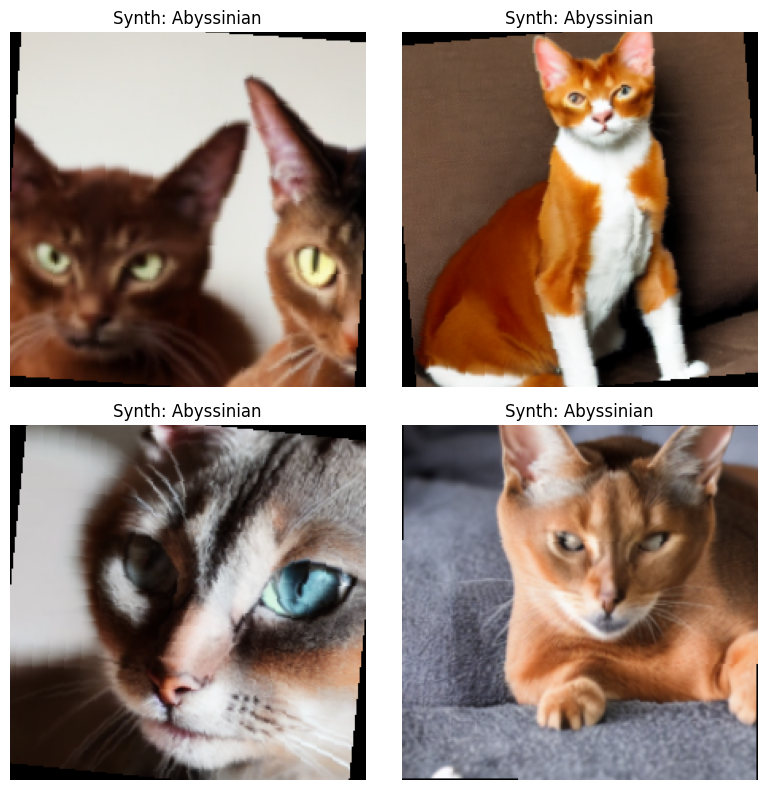

In [ ]:
show_samples(synth_ds, n=4, title_prefix="Synth: ")

In [ ]:
# create a new ResNet-18 model for the extended dataset experiment
model_ext = models.resnet18(pretrained=True)
model_ext.fc = nn.Linear(model_ext.fc.in_features, num_classes)
model_ext = model_ext.to(device)

# optimizer and scheduler for the extended model (same settings as baseline)
optimizer_ext = torch.optim.Adam(model_ext.parameters(), lr=1e-3)
scheduler_ext = torch.optim.lr_scheduler.StepLR(optimizer_ext, step_size=5, gamma=0.1)

In [ ]:
train_model(model_ext, train_extended_loader, val_loader, criterion, optimizer_ext, scheduler_ext, device, 10, len(train_extended_ds))

Epoch 0, Batch 0, Loss: 3.7639
Epoch 0, Batch 50, Loss: 2.7266
Epoch 0, Batch 100, Loss: 1.8959
Epoch 0: Train Loss=2.4286, Val Acc=0.4429
Epoch 1, Batch 0, Loss: 1.7175
Epoch 1, Batch 50, Loss: 1.5768
Epoch 1, Batch 100, Loss: 1.7078
Epoch 1: Train Loss=1.7821, Val Acc=0.5625
Epoch 2, Batch 0, Loss: 1.9498
Epoch 2, Batch 50, Loss: 1.2585
Epoch 2, Batch 100, Loss: 1.8583
Epoch 2: Train Loss=1.5997, Val Acc=0.5000
Epoch 3, Batch 0, Loss: 1.6243
Epoch 3, Batch 50, Loss: 1.3754
Epoch 3, Batch 100, Loss: 1.6514
Epoch 3: Train Loss=1.4820, Val Acc=0.6101
Epoch 4, Batch 0, Loss: 1.2591
Epoch 4, Batch 50, Loss: 0.9932
Epoch 4, Batch 100, Loss: 1.1226
Epoch 4: Train Loss=1.3871, Val Acc=0.6372
Epoch 5, Batch 0, Loss: 0.9817
Epoch 5, Batch 50, Loss: 0.7303
Epoch 5, Batch 100, Loss: 0.7094
Epoch 5: Train Loss=1.0070, Val Acc=0.7921
Epoch 6, Batch 0, Loss: 0.8277
Epoch 6, Batch 50, Loss: 1.2454
Epoch 6, Batch 100, Loss: 1.2928
Epoch 6: Train Loss=0.8289, Val Acc=0.8111
Epoch 7, Batch 0, Loss: 0.4

In [ ]:
# results of extended
final_evaluation_and_save(
    model_ext, train_extended_loader, val_loader, test_loader,
    classes=trainval_base.classes,
    checkpoint_path="extended_resnet18.pth",
    label="Extended"
)


FINAL RESULTS (Extended)
Train Acc: 0.8355
Val Acc:   0.8370
Test Acc:  0.8171

Test Metrics:
Macro Precision: 0.8267
Macro Recall:    0.8166
Macro F1:        0.8142
Extended model saved to extended_resnet18.pth.


In [ ]:
# compute metrics on test set for both models
baseline_results = evaluate(model, test_loader)
extended_results = evaluate(model_ext, test_loader)

comparison_df = pd.DataFrame([
    {
        "Model": "Baseline",
        "Test Accuracy": baseline_results["accuracy"],
        "Macro Precision": baseline_results["macro_precision"],
        "Macro Recall": baseline_results["macro_recall"],
        "Macro F1": baseline_results["macro_f1"],
    },
    {
        "Model": "Extended",
        "Test Accuracy": extended_results["accuracy"],
        "Macro Precision": extended_results["macro_precision"],
        "Macro Recall": extended_results["macro_recall"],
        "Macro F1": extended_results["macro_f1"],
    },
])

comparison_df

,Model,Test Accuracy,Macro Precision,Macro Recall,Macro F1
0,Baseline,0.858817,0.865920,0.858069,0.857047
1,Extended,0.817116,0.826736,0.816590,0.814175


# Results comparison

The experimental results show that extending the training dataset with synthetic images generated through image captioning, paraphrasing, and Stable Diffusion does not improve the performance of the ResNet-18 classifier. Using the same architecture and training setup, the baseline model trained only on real images achieves a test accuracy of 0.859, with a macro precision of 0.866, a macro recall of 0.858, and a macro F1 score of 0.857.
When the synthetic images are added to the training set, the extended model exhibits a noticeable performance drop, reaching a test accuracy of 0.817 and a macro F1 score of 0.814, together with lower macro precision and recall.

These results indicate that, in this experimental setup, the generated images introduce additional noise rather than useful variability, reducing the model’s ability to generalize. In security-related scenarios, where both overall accuracy and class-wise balance are critical, the uncontrolled use of synthetic data can therefore be detrimental.

This work highlights that generative data augmentation is not inherently beneficial. To obtain real improvements, stronger control over the quality of synthetic images would be required, for instance by focusing on rare but realistic situations or by filtering out samples with visible artifacts. Moreover, the impact of synthetic data should always be carefully evaluated under conditions that closely resemble real-world scenarios relevant to critical infrastructure security.

---

## 📚 References & Resources

- [Image Captioning using PyTorch and Transformers in Python](https://eranfeit.net/image-captioning-using-pytorch-and-transformers-in-python/)

- [Image captioning](https://huggingface.co/docs/transformers/main/tasks/image_captioning)

- [Image Captioning with PyTorch Using Transformers](https://medium.com/@omeraykilic1905/image-captioning-with-pytorch-using-transformers-36523d516782)

- [Paraphrase-Generation](https://huggingface.co/Vamsi/T5_Paraphrase_Paws)

- [Text Data Augmentation using Paraphrasing](https://www.youtube.com/watch?v=EDh-FQ7mxGE)

- [How to paraphrase text in Python using transformers](https://www.youtube.com/watch?v=zGK9ZfvRRoM)

- [Text-to-image](https://huggingface.co/docs/diffusers/api/pipelines/stable_diffusion/text2img)

- [Text-to-Image with Stable Diffusion: From Theory to Production](https://medium.com/@amitkharche14/text-to-image-with-stable-diffusion-from-theory-to-production-72320b43ed55)

- Various YouTube videos

- ChatGPT – used for improving documentation clarity and polishing markdown sections
